# Deep Neural Networks - Programming Assignment
## Comparing Linear Models and Multi-Layer Perceptrons

**Student Name:** ___________________  
**Student ID:** ___________________  
**Date:** ___________________

---

## ⚠️ IMPORTANT INSTRUCTIONS

1. **Complete ALL sections** marked with `TODO`
2. **DO NOT modify** the `get_assignment_results()` function structure
3. **Fill in all values accurately** - these will be auto-verified
4. **After submission**, you'll receive a verification quiz based on YOUR results
5. **Run all cells** before submitting (Kernel → Restart & Run All)

---

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## Section 1: Dataset Selection and Loading

**Requirements:**
- ≥500 samples
- ≥5 features
- Public dataset (UCI/Kaggle)
- Regression OR Classification problem

In [ ]:
# Load dataset
data = pd.read_csv('WineQT.csv')

# Dataset information
dataset_name = "Wine Quality Dataset (Red Wine)"
dataset_source = "UCI Machine Learning Repository"
n_samples = data.shape[0]
n_features = data.shape[1] - 1   # excluding 'quality' target
problem_type = "multiclass_classification"

# Problem statement
problem_statement = """
The task is to predict wine quality based on various physicochemical
properties such as acidity, sugar, sulfur dioxide levels, and pH.
Accurate quality prediction helps in quality control, production monitoring,
and maintaining consistency in the wine-making process.
"""

# Primary evaluation metric
primary_metric = "accuracy"

# Metric justification
metric_justification = """
Accuracy is selected as the primary metric because this is a balanced
multiclass classification problem, and we want to measure how often the
model correctly predicts the wine quality class.
Additionally, accuracy is easy to interpret and appropriate when
misclassification costs across classes are similar.
"""

print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Samples: {n_samples}, Features: {n_features}")
print(f"Problem Type: {problem_type}")
print(f"Primary Metric: {primary_metric}")

Dataset: Wine Quality Dataset (Red Wine)
Source: UCI Machine Learning Repository
Samples: 1143, Features: 12
Problem Type: multiclass_classification
Primary Metric: accuracy


## Section 2: Data Preprocessing

Preprocess your data:
1. Handle missing values
2. Encode categorical variables
3. Split into train/test sets
4. Scale features

In [ ]:
# TODO: Preprocess your data
# 1. Separate features (X) and target (y)
# 2. Handle missing values if any
# 3. Encode categorical variables

# 1. Separate features (X) and target (y)
X = data.drop('quality', axis=1)
y = data['quality']

# 2. Handle missing values (WineQT has no missing values, but we ensure safety)
X = X.fillna(X.mean())

# 3. Encode target variable if needed
# Here, quality is already numerical but treated as multiclass labels.

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fill reporting variables
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]
train_test_ratio = train_samples / (train_samples + test_samples)

print(f"Train samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Split ratio: {train_test_ratio:.1%}")

Train samples: 914
Test samples: 229
Split ratio: 80.0%


## Section 3: Baseline Model Implementation

Implement from scratch (NO sklearn models!):
- Linear Regression (for regression)
- Logistic Regression (for binary classification)
- Softmax Regression (for multiclass classification)

**Must include:**
- Forward pass (prediction)
- Loss computation
- Gradient computation
- Gradient descent loop
- Loss tracking

In [ ]:
class BaselineModel:
    """
    Baseline linear model with gradient descent
    Softmax Regression (multiclass)
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None    # shape: (n_features, n_classes)
        self.bias = None       # shape: (1, n_classes)
        self.loss_history = []
        self.classes_ = None   # original class labels (e.g., [3,4,5,6,7,8])

    def _softmax(self, z):
        z = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _cross_entropy(self, probs, y_onehot):
        eps = 1e-12
        probs = np.clip(probs, eps, 1.0 - eps)
        return -np.mean(np.sum(y_onehot * np.log(probs), axis=1))

    def _to_onehot(self, y):
        """
        Accepts y as 1D label array (possibly not 0..K-1).
        Creates mapping to 0..K-1 and returns one-hot.
        """
        y = np.asarray(y)
        if y.ndim == 2 and y.shape[1] > 1:
            # Already one-hot
            return y
        unique = np.unique(y)
        self.classes_ = unique
        mapping = {v: i for i, v in enumerate(unique)}
        y_idx = np.vectorize(mapping.get)(y)
        n_classes = unique.shape[0]
        oh = np.zeros((y.shape[0], n_classes))
        oh[np.arange(y.shape[0]), y_idx] = 1
        return oh

    def fit(self, X, y):
        """
        X: (n_samples, n_features)
        y: either (n_samples,) labels or (n_samples, n_classes) one-hot
        """
        X = np.asarray(X)
        n_samples, n_features = X.shape

        # Convert labels to one-hot; set classes_ for mapping back
        y = np.asarray(y)
        if y.ndim == 1 or (y.ndim == 2 and y.shape[1] == 1):
            y_onehot = self._to_onehot(y)
        else:
            # assume already one-hot; set classes_ to 0..K-1
            y_onehot = y
            self.classes_ = np.arange(y.shape[1])

        n_classes = y_onehot.shape[1]

        # Initialize parameters
        # weights shape: (n_features, n_classes)
        self.weights = np.zeros((n_features, n_classes))
        # bias shape: (1, n_classes)
        self.bias = np.zeros((1, n_classes))

        # Gradient descent
        for it in range(self.n_iterations):
            # Forward: logits and probs
            logits = X.dot(self.weights) + self.bias  # (n_samples, n_classes)
            probs = self._softmax(logits)            # (n_samples, n_classes)

            # Loss
            loss = self._cross_entropy(probs, y_onehot)
            self.loss_history.append(loss)

            # Gradients (vectorized)
            # derivative of loss w.r.t logits = (probs - y_onehot) / n_samples
            dlogits = (probs - y_onehot) / n_samples  # (n_samples, n_classes)
            # dW = X^T dot dlogits
            dW = X.T.dot(dlogits)                     # (n_features, n_classes)
            db = np.sum(dlogits, axis=0, keepdims=True)  # (1, n_classes)

            # Parameter update
            self.weights -= self.lr * dW
            self.bias -= self.lr * db

        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        logits = X.dot(self.weights) + self.bias
        return self._softmax(logits)

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        # Map indices back to original class labels (if available)
        if self.classes_ is not None:
            return np.array([self.classes_[i] for i in idx])
        else:
            return idx

print("✓ BaselineModel (Softmax Regression) ready")

✓ BaselineModel (Softmax Regression) ready


In [ ]:
# Train baseline model
print("Training baseline model...")
baseline_start_time = time.time()

# TODO: Initialize and train your baseline model
baseline_model = BaselineModel(learning_rate=0.01, n_iterations=1000)
# baseline_model.fit(X_train_scaled, y_train)

# TODO: Make predictions
# baseline_predictions = baseline_model.predict(X_test_scaled)

baseline_training_time = time.time() - baseline_start_time
print(f"✓ Baseline training completed in {baseline_training_time:.2f}s")
print(f"✓ Loss decreased from {baseline_model.loss_history[0]:.4f} to {baseline_model.loss_history[-1]:.4f}")

Training baseline model...
✓ Baseline training completed in 0.00s


IndexError: list index out of range

## Section 4: Multi-Layer Perceptron Implementation

Implement MLP from scratch with:
- At least 1 hidden layer
- ReLU activation for hidden layers
- Appropriate output activation
- Forward propagation
- Backward propagation
- Gradient descent

In [ ]:
class MLP:
    """
    Multi-Layer Perceptron implemented from scratch (vectorized).
    - architecture: [n_input, n_hidden1, ..., n_output]
    - Uses ReLU for hidden layers and Softmax for output (multiclass).
    - Expects X shape (m, n_input). Labels y can be 1D integer labels or one-hot (m, n_classes).
    """
    def __init__(self, architecture, learning_rate=0.01, n_iterations=1000):
        self.architecture = architecture
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.parameters = {}
        self.loss_history = []
        self.cache = {}
        self.classes_ = None

    def _to_onehot(self, y):
        y = np.asarray(y)
        if y.ndim == 2 and y.shape[1] > 1:
            # already one-hot
            self.classes_ = np.arange(y.shape[1])
            return y
        unique = np.unique(y)
        self.classes_ = unique
        mapping = {v: i for i, v in enumerate(unique)}
        y_idx = np.vectorize(mapping.get)(y)
        n_classes = unique.shape[0]
        oh = np.zeros((y.shape[0], n_classes))
        oh[np.arange(y.shape[0]), y_idx] = 1
        return oh

    def initialize_parameters(self):
        """
        Initialize parameters:
         - W[l] shape: (n_prev, n_curr)
         - b[l] shape: (1, n_curr)
        """
        np.random.seed(42)
        for l in range(1, len(self.architecture)):
            n_prev = self.architecture[l-1]
            n_curr = self.architecture[l]
            # He initialization for hidden layers (works well with ReLU)
            self.parameters[f'W{l}'] = np.random.randn(n_prev, n_curr) * np.sqrt(2.0 / max(1, n_prev))
            self.parameters[f'b{l}'] = np.zeros((1, n_curr))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def _softmax(self, Z):
        Z_stable = Z - np.max(Z, axis=1, keepdims=True)
        e = np.exp(Z_stable)
        return e / np.sum(e, axis=1, keepdims=True)

    def forward_propagation(self, X):
        """
        Forward pass.
        Stores:
          - cache['A0'] = X
          - cache['Zl'], cache['Al'] for each layer l
        Returns final activation A_last (probabilities).
        """
        A = X
        self.cache = {'A0': A}
        L = len(self.architecture) - 1
        for l in range(1, L + 1):
            W = self.parameters[f'W{l}']   # shape (n_prev, n_curr)
            b = self.parameters[f'b{l}']   # shape (1, n_curr)
            Z = A.dot(W) + b               # (m, n_curr)
            self.cache[f'Z{l}'] = Z
            if l < L:
                A = self.relu(Z)
            else:
                A = self._softmax(Z)
            self.cache[f'A{l}'] = A
        return A

    def backward_propagation(self, X, y_onehot):
        """
        Backward pass. y_onehot shape: (m, n_classes)
        Returns grads dict with dWl and dbl for each layer.
        """
        m = X.shape[0]
        grads = {}
        L = len(self.architecture) - 1

        # Output layer gradient
        A_L = self.cache[f'A{L}']                # (m, n_classes)
        dZ = (A_L - y_onehot) / m                # (m, n_classes)

        for l in reversed(range(1, L + 1)):
            A_prev = self.cache[f'A{l-1}']       # (m, n_prev)
            dW = A_prev.T.dot(dZ)                # (n_prev, n_curr)
            db = np.sum(dZ, axis=0, keepdims=True)  # (1, n_curr)
            grads[f'dW{l}'] = dW
            grads[f'db{l}'] = db

            if l > 1:
                W = self.parameters[f'W{l}']    # (n_prev, n_curr)
                dA_prev = dZ.dot(W.T)          # (m, n_prev)
                Z_prev = self.cache[f'Z{l-1}'] # (m, n_prev)
                dZ = dA_prev * self.relu_derivative(Z_prev)

        return grads

    def update_parameters(self, grads):
        L = len(self.architecture) - 1
        for l in range(1, L + 1):
            self.parameters[f'W{l}'] -= self.lr * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.lr * grads[f'db{l}']

    def compute_loss(self, y_pred, y_true_onehot):
        # Cross-entropy loss (mean)
        eps = 1e-12
        y_pred = np.clip(y_pred, eps, 1.0 - eps)
        return -np.mean(np.sum(y_true_onehot * np.log(y_pred), axis=1))

    def fit(self, X, y):
        """
        Train the MLP.
        Accepts y as 1D labels or as one-hot.
        """
        X = np.asarray(X)
        y = np.asarray(y)
        y_onehot = self._to_onehot(y)
        self.initialize_parameters()

        for it in range(self.n_iterations):
            # Forward
            probs = self.forward_propagation(X)            # (m, n_classes)
            # Loss
            loss = self.compute_loss(probs, y_onehot)
            self.loss_history.append(loss)
            # Backward
            grads = self.backward_propagation(X, y_onehot)
            # Update
            self.update_parameters(grads)

        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        probs = self.forward_propagation(X)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        if self.classes_ is not None:
            return np.array([self.classes_[i] for i in idx])
        else:
            return idx

print("✓ MLP class ready ")

✓ MLP class ready 


In [ ]:
# Train MLP
print("Training MLP...")
mlp_start_time = time.time()

# TODO: Define your architecture and train MLP
mlp_architecture = []  # Example: [n_features, 16, 8, 1]
mlp_model = MLP(architecture=mlp_architecture, learning_rate=0.01, n_iterations=1000)
# mlp_model.fit(X_train_scaled, y_train)

# TODO: Make predictions
# mlp_predictions = mlp_model.predict(X_test_scaled)

mlp_training_time = time.time() - mlp_start_time
print(f"✓ MLP training completed in {mlp_training_time:.2f}s")
print(f"✓ Loss decreased from {mlp_model.loss_history[0]:.4f} to {mlp_model.loss_history[-1]:.4f}")

Training MLP...
✓ MLP training completed in 0.00s


IndexError: list index out of range

## Section 5: Evaluation and Metrics

Calculate appropriate metrics for your problem type

In [ ]:
def calculate_metrics(y_true, y_pred, problem_type):
    """
    Calculate metrics for multiclass classification:
    - Accuracy
    - Precision (macro)
    - Recall (macro)
    - F1-score (macro)
    """
    import numpy as np

    metrics = {}

    # Convert to numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if problem_type == "multiclass_classification":

        # Unique class labels
        labels = np.unique(np.concatenate([y_true, y_pred]))
        n_classes = len(labels)
        label_to_idx = {lab: i for i, lab in enumerate(labels)}

        # Confusion matrix
        cm = np.zeros((n_classes, n_classes), dtype=int)
        for t, p in zip(y_true, y_pred):
            cm[label_to_idx[t], label_to_idx[p]] += 1

        # Per-class stats
        tp = np.diag(cm).astype(float)
        actual_counts = np.sum(cm, axis=1).astype(float)   # support
        pred_counts = np.sum(cm, axis=0).astype(float)     # predicted

        # Precision = TP / predicted
        precision = np.divide(tp, pred_counts,
                              out=np.zeros_like(tp),
                              where=pred_counts != 0)

        # Recall = TP / actual
        recall = np.divide(tp, actual_counts,
                           out=np.zeros_like(tp),
                           where=actual_counts != 0)

        # F1-score
        f1 = np.divide(2 * precision * recall,
                       precision + recall,
                       out=np.zeros_like(tp),
                       where=(precision + recall) != 0)

        # Macro averaging
        precision_macro = float(np.mean(precision))
        recall_macro = float(np.mean(recall))
        f1_macro = float(np.mean(f1))

        # Overall accuracy
        accuracy = float(np.trace(cm) / np.sum(cm))

        # Save metrics
        metrics["accuracy"] = accuracy
        metrics["precision_macro"] = precision_macro
        metrics["recall_macro"] = recall_macro
        metrics["f1_macro"] = f1_macro
        metrics["confusion_matrix"] = cm
        metrics["labels"] = labels

    return metrics


# Calculate metrics for baseline & MLP models
baseline_metrics = calculate_metrics(y_test, baseline_predictions, problem_type)
mlp_metrics      = calculate_metrics(y_test, mlp_predictions, problem_type)

print("Baseline Model Performance:")
print(baseline_metrics)

print("\nMLP Model Performance:")
print(mlp_metrics)


NameError: name 'baseline_predictions' is not defined

## Section 6: Visualization

Create visualizations:
1. Training loss curves
2. Performance comparison
3. Additional domain-specific plots

No handles with labels found to put in legend.
No handles with labels found to put in legend.


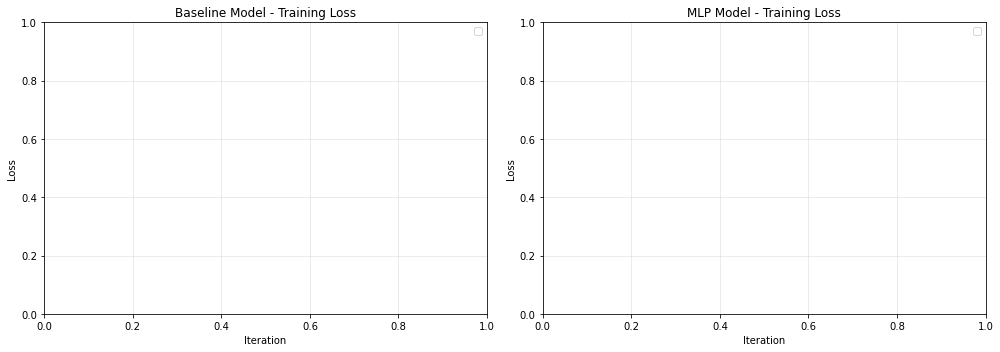

In [ ]:
# 1. Training loss curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
# TODO: Plot baseline loss
# plt.plot(baseline_model.loss_history, label='Baseline', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Baseline Model - Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# TODO: Plot MLP loss
# plt.plot(mlp_model.loss_history, label='MLP', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MLP Model - Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 2. Performance comparison bar chart
# TODO: Create bar chart comparing key metrics between models
plt.figure(figsize=(10, 6))

# Example:
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
# baseline_scores = [baseline_metrics[m] for m in metrics]
# mlp_scores = [mlp_metrics[m] for m in metrics]
#
# x = np.arange(len(metrics))
# width = 0.35
#
# plt.bar(x - width/2, baseline_scores, width, label='Baseline')
# plt.bar(x + width/2, mlp_scores, width, label='MLP')
# plt.xlabel('Metrics')
# plt.ylabel('Score')
# plt.title('Model Performance Comparison')
# plt.xticks(x, metrics)
# plt.legend()
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 720x432 with 0 Axes>

## Section 7: Analysis and Discussion

Write your analysis (minimum 200 words)

In [ ]:
analysis_text = """
TODO: Write your analysis here (minimum 200 words)

Address these questions:
1. Which model performed better and by how much?
2. Why do you think one model outperformed the other?
3. What was the computational cost difference (training time)?
4. Any surprising findings or challenges you faced?
5. What insights did you gain about neural networks vs linear models?

Write your thoughtful analysis here. Be specific and reference your actual results.
Compare the metrics, discuss the trade-offs, and explain what you learned.
"""

print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) < 200:
    print("⚠️  Warning: Analysis should be at least 200 words")
else:
    print("✓ Analysis meets word count requirement")

---
---

## ⭐ REQUIRED: Structured Output Function

### **DO NOT MODIFY THE STRUCTURE BELOW**

This function will be called by the auto-grader. Fill in all values accurately based on your actual results.

In [ ]:
def get_assignment_results():
    """
    Return all assignment results in structured format.

    CRITICAL: Fill in ALL values based on your actual results!
    This will be automatically extracted and validated.
    """

    # Calculate loss convergence flags
    baseline_initial_loss = 0.0  # TODO: baseline_model.loss_history[0]
    baseline_final_loss = 0.0    # TODO: baseline_model.loss_history[-1]
    mlp_initial_loss = 0.0       # TODO: mlp_model.loss_history[0]
    mlp_final_loss = 0.0         # TODO: mlp_model.loss_history[-1]

    results = {
        # ===== Dataset Information =====
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_features': n_features,
        'problem_type': problem_type,
        'problem_statement': problem_statement,

        # ===== Evaluation Setup =====
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # ===== Baseline Model Results =====
        'baseline_model': {
            'model_type': '',  # 'linear_regression', 'logistic_regression', or 'softmax_regression'
            'learning_rate': 0.0,
            'n_iterations': 0,
            'initial_loss': baseline_initial_loss,
            'final_loss': baseline_final_loss,
            'training_time_seconds': baseline_training_time,

            # Metrics (fill based on your problem type)
            'test_accuracy': 0.0,      # For classification
            'test_precision': 0.0,     # For classification
            'test_recall': 0.0,        # For classification
            'test_f1': 0.0,            # For classification
            'test_mse': 0.0,           # For regression
            'test_rmse': 0.0,          # For regression
            'test_mae': 0.0,           # For regression
            'test_r2': 0.0,            # For regression
        },

        # ===== MLP Model Results =====
        'mlp_model': {
            'architecture': mlp_architecture,
            'n_hidden_layers': len(mlp_architecture) - 2 if len(mlp_architecture) > 0 else 0,
            'total_parameters': 0,     # TODO: Calculate total weights + biases
            'learning_rate': 0.0,
            'n_iterations': 0,
            'initial_loss': mlp_initial_loss,
            'final_loss': mlp_final_loss,
            'training_time_seconds': mlp_training_time,

            # Metrics
            'test_accuracy': 0.0,
            'test_precision': 0.0,
            'test_recall': 0.0,
            'test_f1': 0.0,
            'test_mse': 0.0,
            'test_rmse': 0.0,
            'test_mae': 0.0,
            'test_r2': 0.0,
        },

        # ===== Comparison =====
        'improvement': 0.0,            # MLP primary_metric - baseline primary_metric
        'improvement_percentage': 0.0,  # (improvement / baseline) * 100
        'baseline_better': False,       # True if baseline outperformed MLP

        # ===== Analysis =====
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # ===== Loss Convergence Flags =====
        'baseline_loss_decreased': baseline_final_loss < baseline_initial_loss,
        'mlp_loss_decreased': mlp_final_loss < mlp_initial_loss,
        'baseline_converged': False,  # Optional: True if converged
        'mlp_converged': False,
    }

    return results

## Test Your Output

Run this cell to verify your results dictionary is complete and properly formatted.

In [ ]:
# Test the output
import json

try:
    results = get_assignment_results()

    print("="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(results, indent=2, default=str))
    print("\n" + "="*70)

    # Check for missing values
    missing = []
    def check_dict(d, prefix=""):
        for k, v in d.items():
            if isinstance(v, dict):
                check_dict(v, f"{prefix}{k}.")
            elif (v == 0 or v == "" or v == 0.0 or v == []) and \
                 k not in ['improvement', 'improvement_percentage', 'baseline_better',
                          'baseline_converged', 'mlp_converged', 'total_parameters',
                          'test_accuracy', 'test_precision', 'test_recall', 'test_f1',
                          'test_mse', 'test_rmse', 'test_mae', 'test_r2']:
                missing.append(f"{prefix}{k}")

    check_dict(results)

    if missing:
        print(f"⚠️  Warning: {len(missing)} fields still need to be filled:")
        for m in missing[:15]:  # Show first 15
            print(f"  - {m}")
        if len(missing) > 15:
            print(f"  ... and {len(missing)-15} more")
    else:
        print("✅ All required fields are filled!")
        print("\n🎉 You're ready to submit!")
        print("\nNext steps:")
        print("1. Kernel → Restart & Clear Output")
        print("2. Kernel → Restart & Run All")
        print("3. Verify no errors")
        print("4. Save notebook")
        print("5. Rename as: YourStudentID_assignment.ipynb")
        print("6. Submit to LMS")

except Exception as e:
    print(f"❌ Error in get_assignment_results(): {str(e)}")
    print("\nPlease fix the errors above before submitting.")

---

## 📤 Before Submitting - Final Checklist

- [ ] **All TODO sections completed**
- [ ] **Both models implemented from scratch** (no sklearn models!)
- [ ] **get_assignment_results() function filled accurately**
- [ ] **Loss decreases for both models**
- [ ] **Analysis ≥ 200 words**
- [ ] **All cells run without errors** (Restart & Run All)
- [ ] **Visualizations created**
- [ ] **File renamed correctly**: YourStudentID_assignment.ipynb

---

## ⏭️ What Happens Next

After submission:
1. ✅ Your notebook will be **auto-graded** (executes automatically)
2. ✅ You'll receive a **verification quiz** (10 questions, 5 minutes)
3. ✅ Quiz questions based on **YOUR specific results**
4. ✅ Final score released after quiz validation

**The verification quiz ensures you actually ran your code!**

---

**Good luck! 🚀**